https://blog.csdn.net/ch206265/article/details/106962354

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Set Device

In [16]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### input data

In [17]:
flight_data = sns.load_dataset("flights")
print(flight_data.head())
print(flight_data.shape)

   year month  passengers
0  1949   Jan         112
1  1949   Feb         118
2  1949   Mar         132
3  1949   Apr         129
4  1949   May         121
(144, 3)


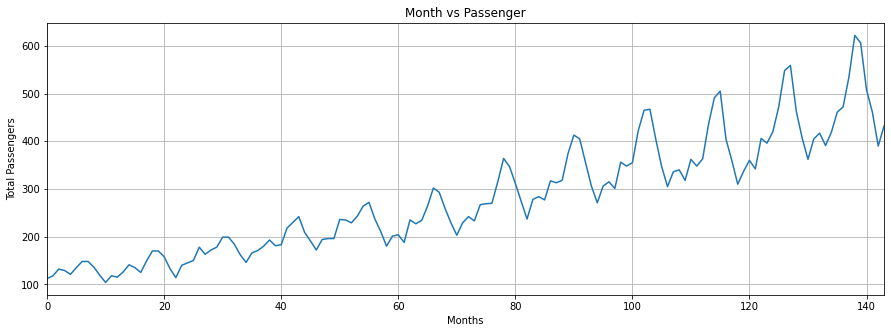

In [18]:
fig_size = plt.rcParams['figure.figsize']
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams['figure.figsize'] = fig_size
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.xlabel('Months')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'])
plt.show()

In [19]:
'''數據預處理'''

flight_data.columns
all_data = flight_data['passengers'].values.astype(float)

# 切割測試集與訓練集
test_data_size = 12
train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

print(len(train_data))
print(len(test_data))

132
12


In [20]:
# 歸一化
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))
train_data_normalized = scaler.fit_transform(train_data.reshape(-1,1))

print(train_data_normalized[:5])
print(train_data_normalized[-5:])

train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
# view 相當於 numpy 的 resize，參數代表數組不同維的維度

[[-0.96483516]
 [-0.93846154]
 [-0.87692308]
 [-0.89010989]
 [-0.92527473]]
[[1.        ]
 [0.57802198]
 [0.33186813]
 [0.13406593]
 [0.32307692]]


In [21]:
def create_inout_sequences(input_data, tw): # tw, train window
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq, train_label))
    return inout_seq

train_window = 12
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
print(train_inout_seq[:5])

'''
作者按：
create_inout_sequence return 的元組列表由一個個的序列組成，
每一個序列有13的數據，分別是設置的12個數據（train_window）＋第13的數據（label）
每一個序列由前12個數據組成，第13個數據是第一個序列的label。
同樣，第二個數列從第二個數據開始到第十三個數據結束，而第十四個數據則是第二個序列的標籤，依此類推'''

[(tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
        -0.8593, -0.9341, -1.0000, -0.9385]), tensor([-0.9516])), (tensor([-0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593,
        -0.9341, -1.0000, -0.9385, -0.9516]), tensor([-0.9033])), (tensor([-0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341,
        -1.0000, -0.9385, -0.9516, -0.9033]), tensor([-0.8374])), (tensor([-0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000,
        -0.9385, -0.9516, -0.9033, -0.8374]), tensor([-0.8637])), (tensor([-0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000, -0.9385,
        -0.9516, -0.9033, -0.8374, -0.8637]), tensor([-0.9077]))]


'\n作者按：\ncreate_inout_sequence return 的元組列表由一個個的序列組成，\n每一個序列有13的數據，分別是設置的12個數據（train_window）＋第13的數據（label）\n每一個序列由前12個數據組成，第13個數據是第一個序列的label。\n同樣，第二個數列從第二個數據開始到第十三個數據結束，而第十四個數據則是第二個序列的標籤，依此類推'

### 創建LSTM模型
* input_size: 對應的特徵數量，在這個例子裡是"1"，即passengers
* output_size: 預測變量的個數，以及數據標籤的個數
* hidden_layer_size: 隱藏層的特徵數，亦即隱藏層神經元數

In [22]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size, device=device),
                            torch.zeros(1, 1, self.hidden_layer_size, device=device))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1),
                                               self.hidden_cell)

        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [23]:
model = LSTM()
model = model.to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [26]:
epochs = 300
for i in range(epochs):
    for seq, labels in train_inout_seq:
        seq = seq.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size, device=device),
                             torch.zeros(1, 1, model.hidden_layer_size, device=device))
        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i % 25 == 1:
        print(f'epoch:{i,3} loss:{single_loss.item():10.8f}')
print(f'epoch:{i:3} loss:{single_loss.item():10.10f}')

epoch:(1, 3) loss:0.00866042
epoch:(26, 3) loss:0.00834449
epoch:(51, 3) loss:0.00007319
epoch:(76, 3) loss:0.00635350
epoch:(101, 3) loss:0.00054718
epoch:(126, 3) loss:0.00219901
epoch:(151, 3) loss:0.02646901
epoch:(176, 3) loss:0.00067512
epoch:(201, 3) loss:0.00014593
epoch:(226, 3) loss:0.00120709
epoch:(251, 3) loss:0.00000511
epoch:(276, 3) loss:0.00665923
epoch:299 loss:0.0000000662


In [27]:
fut_pred = 12
test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[0.12527473270893097, 0.04615384712815285, 0.3274725377559662, 0.2835164964199066, 0.3890109956264496, 0.6175824403762817, 0.9516483545303345, 1.0, 0.5780220031738281, 0.33186814188957214, 0.13406594097614288, 0.32307693362236023]


In [29]:
model.eval()
for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    seq = seq.to(device)
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size, device=device),
                        torch.zeros(1, 1, model.hidden_layer_size, device=device))
        test_inputs.append(model(seq).item())

print(test_inputs[fut_pred:])


actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:]).reshape(-1,1))
print(actual_predictions)

[0.2408795952796936, 0.2677724361419678, 0.2790624797344208, 0.24003079533576965, 0.4435921907424927, 0.5461638569831848, 0.7378515601158142, 0.873115062713623, 0.994053840637207, 0.9979333877563477, 1.0836045742034912, 1.2213432788848877]
[[386.30010793]
 [392.41822922]
 [394.98671414]
 [386.10700594]
 [432.41722339]
 [455.75227746]
 [499.36122993]
 [530.13367677]
 [557.64724874]
 [558.52984571]
 [578.02004063]
 [609.35559595]]


### 根據實際值，繪製預測值

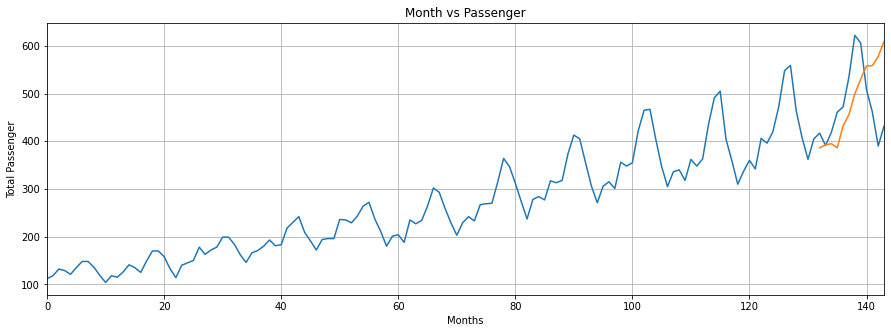

In [30]:
x = np.arange(132, 132+fut_pred, 1)
plt.title('Month vs Passenger')
plt.ylabel('Total Passenger')
plt.xlabel('Months')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'])
plt.plot(x, actual_predictions)
plt.show()

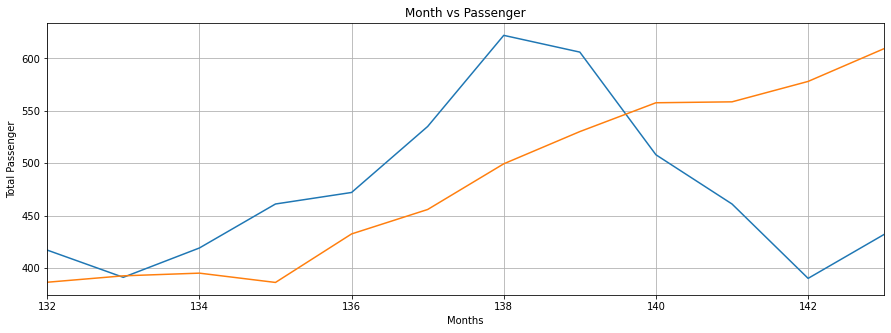

In [31]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passenger')
plt.xlabel('Months')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'][-train_window:])
plt.plot(x, actual_predictions)
plt.show()